# Notebook Summary

# Setup & Imports

In [932]:
import json
import requests
from lxml import html
from collections import OrderedDict
import argparse
import re
import dateutil.parser
import pandas as pd
import time
from textatistic import Textatistic
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime

# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
from scipy import stats
from scipy import special
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error 
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.regressor.alphas import AlphaSelection

%matplotlib inline


# Read in data:
* 3778 articles scraped from all followers & followees of Jonathan Morgan
* 2133 unique user profiles with metadata

In [971]:
df = pd.read_pickle('jonathonmorgan_articles_claps_redo_df.pkl')

In [943]:
users_dict = pd.read_pickle('pickles/jonathonmorgan_master_people.pkl')
users = pd.DataFrame.from_dict(users_dict).T

users.reset_index(level=0, inplace=True)
users.rename(columns = {'index':'author'},inplace = True)

## Format User Data

In [944]:
#fix the 'K's and 'M's in the data
followers_num = []
leaders_num = []

def fix_K_or_M(to_list, from_series):
    for n in from_series:
        if ' Follower' in str(n):
            n = re.sub(' Follower','',n)
            to_list.append(int(n))
        elif 'K' in str(n):
            n = re.sub('K','',n)
            n = float(n) * 1000
            to_list.append(int(n))
        elif 'M' in str(n):
            n = re.sub('M','',n)
            n = float(n) * 1000000
            to_list.append(int(n))
        else: 
            n = float(n)
            to_list.append(int(n))

fix_K_or_M(followers_num,users['followers'])
fix_K_or_M(leaders_num,users['leaders'])

users['followers_num'] = followers_num
users['leaders_num'] = leaders_num

users = users.drop(columns = ['followers']);
users = users.drop(columns = ['leaders']);

users.head()

,author,name,followers_num,leaders_num
0,https://medium.com/@243,243,9,52
1,https://medium.com/@2kdei,Kristina Dei,1200,2300
2,https://medium.com/@7piliers,Brendan McDonald,6600,9000
3,https://medium.com/@AJKnuppe,Austin Knuppe,49,519
4,https://medium.com/@ATXTechRecruitr,Antonio Busalacchi,51,238


# Clean the data

* Evaluate Nans in dataset - confirmed that Nans were valid and dropped missing data
* Fix numeric issues with 'K' and "M' for thousands and millions
* Change column types to int/float and make datetime derivatives

## Evaluate Nans in data & drop rows with Nan

In [945]:
count_nan = len(df) - df.count()
count_nan

url               0
author           11
claps             0
datetime         11
flesch           18
images            0
language          0
polarity          0
publisher         0
reading_time    360
sentences         0
subjectivity      0
tags              0
words             0
dtype: int64

In [946]:
df_m = df.dropna()
df_m.shape

(3401, 14)

## Clean the existing data columns

In [841]:
df_m.dtypes

url             object
author          object
claps           object
datetime        object
flesch          object
images          object
language        object
polarity        object
publisher       object
reading_time    object
sentences       object
subjectivity    object
tags            object
words           object
dtype: object

In [842]:
# drop languages besides english
df_m = df_m[df_m['language'] == 'en']
df_m = df_m.drop(columns = ['language']);
df_m.shape

(3234, 13)

In [949]:
#fix claps with a 'K' to be in thousands & convert to int
claps_num = []

for clap in df_m['claps']:
    if 'K' in str(clap):
        clap = re.sub('K','',clap)
        clap = float(clap) * 1000
        claps_num.append(clap)
    else: 
        clap = float(clap)
        claps_num.append(clap)

df_m['claps_num'] = claps_num
df_m['claps_num'] = df_m.claps_num.astype(int)
df_m = df_m.drop(columns = ['claps']);

In [950]:
# fix reading_time variable so it can be an int

article_reading_time = []

for time in df_m['reading_time']:
    if 'min read' in str(time):
        time = re.sub('min read','',time)
        time = int(time)
        article_reading_time.append(time)
    else: 
        time = int(time)
        article_reading_time.append(time)

df_m['article_reading_time'] = article_reading_time
df_m['article_reading_time'] = df_m.article_reading_time.astype(int)
df_m = df_m.drop(columns = ['reading_time']);

In [951]:
#get rid of negative flesch scores
df_m = df_m[df_m['flesch'] >= 0 ]
df_m = df_m[df_m['flesch'] <100 ]

In [952]:
#fix datetime variable and derive other date-oriented variables

fixed_datetime = []
for datetime in df_m['datetime']:
    datetime = datetime[:-5]
    datetime = re.sub('T',' ',datetime)
    fixed_datetime.append(datetime)
    
df_m['datetime_full'] = fixed_datetime
df_m['datetime_full'] =  pd.to_datetime(df_m['datetime_full'], format='%Y-%m-%d %H:%M:%S')

df_m = df_m.drop(columns = ['datetime'])

df_m['year'] = df_m['datetime_full'].dt.year.astype(int)
df_m['hour'] = df_m['datetime_full'].dt.hour.astype(int)
df_m['day_of_week'] = df_m['datetime_full'].dt.weekday.astype(int)
df_m = df_m.drop(columns = ['datetime_full']);

In [953]:
# fix other data types
df_m['sentences'] = df_m.sentences.astype(int)
df_m['words'] = df_m.words.astype(int)
df_m['publisher'] = df_m.publisher.astype(int)
df_m['flesch'] = df_m.flesch.astype(float)
df_m['polarity'] = df_m.polarity.astype(float)
df_m['subjectivity'] = df_m.subjectivity.astype(float)
df_m['images'] = df_m.images.astype(int)

## Working with tags

Tags data is currently in a list within the column, this section breaks out tags into usable categorical variables


In [848]:
#create a column for the number of tags
num_tags = []
for tags in df_m['tags']:
    num_tags.append(len(tags))
num_tags

df_m['num_tags'] = num_tags

In [849]:
#create a dicitonary of all the tags
d = {}
for t in df_m['tags']:
    for i in t:
        d[i] = d.get(i,0) + 1

In [850]:
tags_frequency = pd.DataFrame(d, index=[0])
tags_frequency = tags_frequency.T

tags_frequency.reset_index(level=0, inplace=True)
tags_frequency.rename(columns = {'index':'tag', 0:'count'},inplace = True)
tags_frequency.sort_values('count', ascending =False)



,tag,count
680,Data Science,330
2128,Politics,250
2600,Startup,217
1661,Machine Learning,211
154,Artificial Intelligence,178
2693,Tech,153
253,Big Data,125
2701,Technology,113
924,Entrepreneurship,107
2527,Social Media,106


In [851]:
#toss out tags with a count < 46 articles (Jonathan chose this # w/ his  magic)
d_top = { k:v for k, v in d.items() if v > 46 }

In [852]:
#loop through each row in the original dataframe, and make a dictionary of the tags & counts
#basically all possible tags, with a 0 or 1

def get_tags_dict2(df):
    tags_dict = {}
    i = 0
    for row in df['tags']:
        row_dict = {}
        for key, value in d_top.items():
            if key in row:
                row_dict[key] = 1
            else:
                row_dict[key] = 0
        tags_dict.update({i : row_dict})
        i +=1
    return tags_dict

def get_tags_dict3(df):
    tags_dict = {}
    i = 0
    for index, row in df.iterrows():
        row_dict = {}
        for tag in row['tags']:
            if tag in d_top:
                row_dict[tag] = 1
            else:
                row_dict[tag] = 0
        tags_dict.update({row['url'] : row_dict})
        i +=1
    return tags_dict

def get_tags_dict(df):
    tags_dict = {}
    i = 0
    for index, row in df.iterrows():
        row_dict = {}
        for key, value in d_top.items():
            if key in row['tags']:
                row_dict[key] = 1
            else:
                row_dict[key] = 0
        tags_dict.update({row['url'] : row_dict})
        i +=1
    return tags_dict

tags_dict = get_tags_dict(df_m)
df_tags = pd.DataFrame.from_dict(tags_dict).T
df_m = df_m.drop(columns = ['tags']);

In [853]:

df_tags.reset_index(level=0, inplace=True)
df_tags.rename(columns = {'index':'url'},inplace = True)
df_tags

,url,2016 Election,AI,Artificial Intelligence,Big Data,Bots,Business,Data,Data Science,Data Visualization,...,Product Management,Productivity,Programming,Python,Social Media,Software Development,Sports,Startup,Tech,Technology
0,https://42hire.com/recruiters-time-to-get-with...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,https://42hire.com/recruiters-where-are-you-1e...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,https://42hire.com/your-resume-or-cv-can-they-...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,https://aboveintelligent.com/why-a-i-agents-wo...,0,1,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,https://arcdigital.media/facebook-faces-the-mu...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,https://artplusmarketing.com/a-series-treasure...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,https://artplusmarketing.com/ais-road-to-the-m...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,https://artplusmarketing.com/data-literacy-pro...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,https://artplusmarketing.com/photo-friday-7-28...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,https://artplusmarketing.com/photo-friday-8-18...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [854]:
#add tags to the dataframe
# df_total = df_m.join(df_tags)
df_total = pd.merge(df_m, df_tags, on='url')
df_total

,url,author,flesch,images,polarity,publisher,sentences,subjectivity,words,claps_num,...,Product Management,Productivity,Programming,Python,Social Media,Software Development,Sports,Startup,Tech,Technology
0,https://42hire.com/recruiters-time-to-get-with...,https://42hire.com/@IanCalvert,70.592395,0,0.142622,1,13,0.414637,785,4,...,0,0,0,0,0,0,0,0,0,0
1,https://42hire.com/recruiters-where-are-you-1e...,https://42hire.com/@IanCalvert,63.504384,0,0.151307,1,16,0.319911,475,1,...,0,0,0,0,0,0,0,0,0,1
2,https://42hire.com/your-resume-or-cv-can-they-...,https://42hire.com/@IanCalvert,69.322964,0,0.125421,1,19,0.312650,646,1,...,0,0,0,0,0,0,0,0,0,0
3,https://aboveintelligent.com/why-a-i-agents-wo...,https://aboveintelligent.com/@OliverChristie,65.054957,4,0.123980,1,44,0.525696,739,17,...,0,1,0,0,0,0,0,0,0,0
4,https://arcdigital.media/facebook-faces-the-mu...,https://arcdigital.media/@melissaryan,68.712533,1,0.116732,1,58,0.478562,1003,157,...,0,0,0,0,0,0,0,0,0,0
5,https://artplusmarketing.com/a-series-treasure...,https://artplusmarketing.com/@NikkiElizDemere,62.857885,12,0.211905,1,14,0.338095,67,52,...,0,0,0,0,0,0,0,0,0,0
6,https://artplusmarketing.com/ais-road-to-the-m...,https://artplusmarketing.com/@mikiobraun,65.110018,0,0.093370,1,84,0.472229,1824,68,...,0,0,0,0,0,0,0,0,0,0
7,https://artplusmarketing.com/data-literacy-pro...,https://artplusmarketing.com/@mrogati,71.318307,2,0.088030,1,50,0.514859,739,135,...,0,0,0,0,0,0,0,0,0,0
8,https://artplusmarketing.com/photo-friday-7-28...,https://artplusmarketing.com/@NikkiElizDemere,67.385596,18,0.054167,1,15,0.214583,73,7,...,0,0,0,0,0,0,0,0,0,0
9,https://artplusmarketing.com/photo-friday-8-18...,https://artplusmarketing.com/@NikkiElizDemere,66.303553,12,0.054167,1,15,0.214583,75,13,...,0,0,0,0,0,0,0,0,0,0


In [855]:
# df_total[df_total['url']=='https://medium.com/@michaeldsimmons/forget-about-the-10-000-hour-rule-7b7a39343523'].T

# Merge in user metadata dataframe

In [856]:
total = users.merge(df_total,left_on='author',right_on='author',how = 'inner')



In [857]:
total.shape

(2641, 50)

In [858]:
total = total.dropna()

In [859]:
# remove @MediumStaff and @Medium - too many followers, and not really a true account
# total = total[(total['author'] != 'https://medium.com/@MediumStaff')&(total['author'] != 'https://medium.com/@Medium')  &(total['author'] != 'https://medium.com/@jonahlupton') & (total['author'] != 'https://medium.com/@anildash') & (total['url'] != 'https://medium.com/@kallunalovegood/new-years-here-we-galapagos-2012-2013-bee5e5dfcba4')].sort_values('followers_num', ascending = False)
total = total[(total['author'] != 'https://medium.com/@MediumStaff')&(total['author'] != 'https://medium.com/@Medium')]

In [860]:
#move url column over to make thigs easier
cols = total.columns.tolist()
cols = cols[:2] + cols[4:5] + cols[2:4] + cols[5:]
total = total[cols]


# EDA
Examine spread & relationships for variables
Normalize highly skewed vairabels (e.g. claps)

In [861]:
#this function is just generally helpful for indexing columns
def print_columns(df):
    i = 0
    for c in df.columns:
        print (str(i)+ ' '+ c)
        i +=1

In [862]:
 print_columns(total)

0 author
1 name
2 url
3 followers_num
4 leaders_num
5 flesch
6 images
7 polarity
8 publisher
9 sentences
10 subjectivity
11 words
12 claps_num
13 article_reading_time
14 year
15 hour
16 day_of_week
17 num_tags
18 2016 Election
19 AI
20 Artificial Intelligence
21 Big Data
22 Bots
23 Business
24 Data
25 Data Science
26 Data Visualization
27 Design
28 Donald Trump
29 Education
30 Entrepreneurship
31 Government
32 Health
33 Journalism
34 Life
35 Life Lessons
36 Machine Learning
37 Marketing
38 Open Data
39 Politics
40 Product Management
41 Productivity
42 Programming
43 Python
44 Social Media
45 Software Development
46 Sports
47 Startup
48 Tech
49 Technology


Text(0.5,1,'claps_num')

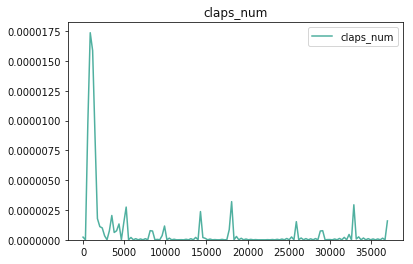

In [863]:
#plot used for analysis of variables
column_name = 'claps_num'
sns.kdeplot(total[column_name], color = '#50B0A0').set_title(column_name)

The following variables are highly right-skewed:

* followers_num
* leaders_num
* images
* sentences
* words
* claps_num
* article_reading_time

In [921]:
#total percept with zero claps
len(total[total['claps_num']==0])/len(total)

0.2824601366742597

## Run normalizations on skewed variables for analysis

In [867]:
#Standard scaler - z-scores the data to normalize it between (-3,3)
scaler = StandardScaler()
scaler.fit(total[['claps_num']])
scaler_output = (scaler.transform(total[['claps_num']]))
total['claps_scalar'] = scaler_output
# Note to reverse: scaler.inverse_transform(scaler_output)

In [868]:
# Robust Scaler -  removes the median and scales the data according to the quantile range 
robustscaler = RobustScaler()
robustscaler.fit(total[['claps_num']])
robustscaler_output = (robustscaler.transform(total[['claps_num']]))
total['claps_robust_scalar'] = robustscaler_output
# Note to reverse: robustscaler.inverse_transform(robustscaler_output)

In [965]:
#Run box cox after scaler, and on the raw data
# add one to columns with large spread and value of 0
total['claps_scalar_boxcox'] = stats.boxcox((total['claps_scalar']+1))[0]
total['claps_robust_boxcox'] = stats.boxcox((total['claps_robust_scalar']+1))[0]
total['claps_boxcox'] = stats.boxcox((total['claps_num']+1))[0]
df_m['claps_boxcox'] = stats.boxcox((df_m['claps_num']+1))[0]

total['leaders_boxcox'] = stats.boxcox((total['leaders_num']+1))[0]
total['followers_boxcox'] = stats.boxcox((total['followers_num']+1))[0]
total['article_reading_time_boxcox'] = stats.boxcox((total['article_reading_time']))[0]
total['words_boxcox'] = stats.boxcox((total['words']))[0]
total['sentences_boxcox'] = stats.boxcox((total['sentences']))[0]
total['images_boxcox'] = stats.boxcox((total['images'])+1)[0]



In [870]:
#Get lambda for later un-box-coxing
_, lmb= stats.boxcox((total['claps_num']+1))
claps_boxcox_lmb = lmb
claps_boxcox_lmb

-0.27511283186067265

In [871]:
plt.rcParams.update(plt.rcParamsDefault)

## evaluate normalizations

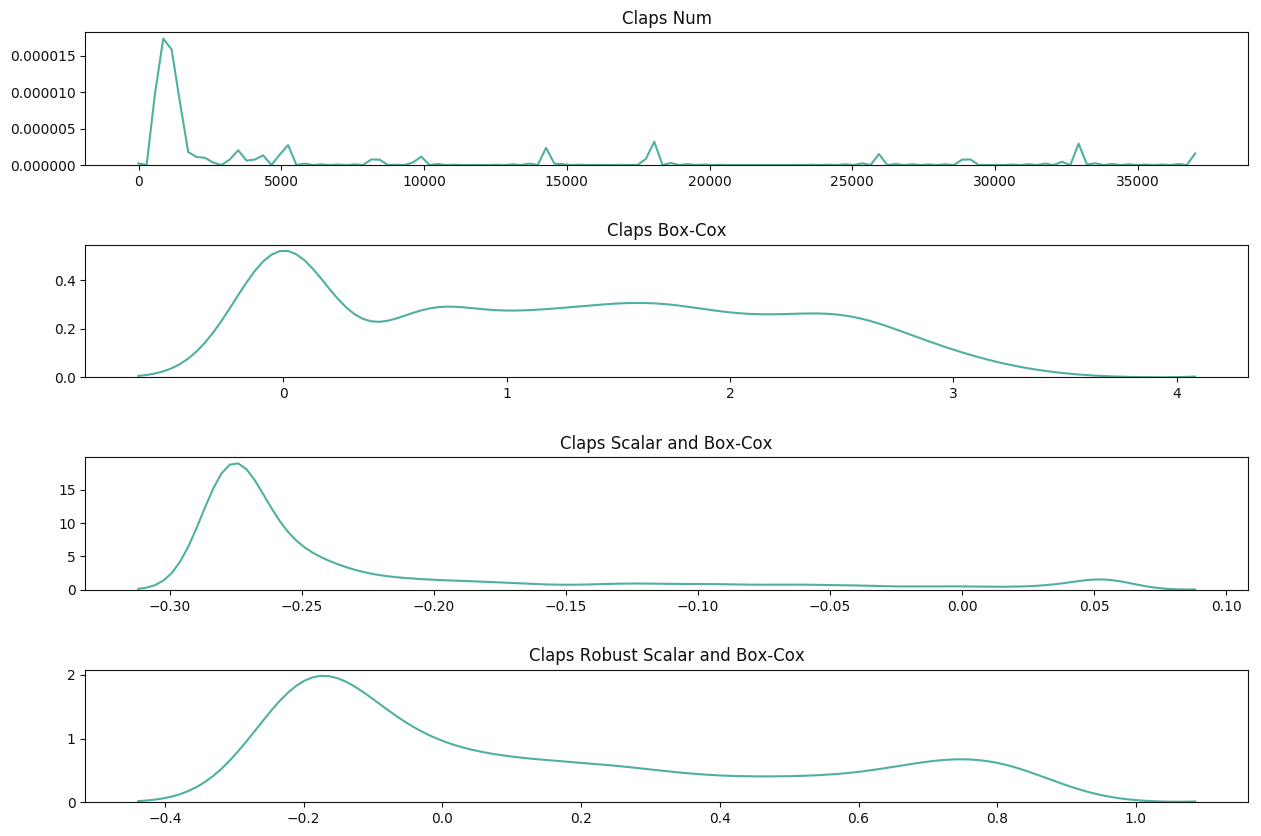

In [872]:
# Evaluate the various transformations on claps
plt.subplots( figsize=(15,10))
plt.subplots_adjust(wspace = 0.2,hspace = 0.6)
plt.subplot(4, 1, 1)
ax2 = sns.kdeplot(total['claps_num'], color = '#50B0A0',legend = False).set_title('Claps Num')
plt.subplot(4, 1, 2)
sns.kdeplot(total['claps_boxcox'], color = '#50B0A0', legend = False).set_title('Claps Box-Cox')
plt.subplot(4, 1, 3)
ax2 = sns.kdeplot(total['claps_scalar_boxcox'], color = '#50B0A0',legend = False).set_title('Claps Scalar and Box-Cox')
plt.subplot(4, 1, 4)
ax2 = sns.kdeplot(total['claps_robust_boxcox'], color = '#50B0A0',legend = False).set_title('Claps Robust Scalar and Box-Cox')


Text(0.5,1,'Leaders Box-Cox')

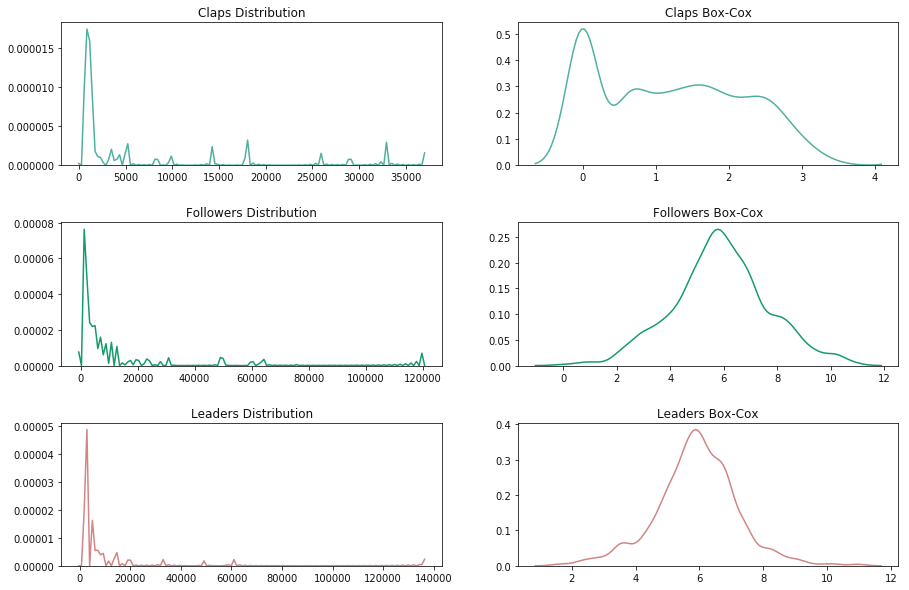

In [990]:
# Evaluate other variable transformations
fig, ax = plt.subplots(3, 2, figsize=(15,10))

plt.subplots_adjust(wspace = 0.2,hspace = 0.4 )

ax2 = sns.kdeplot(total['claps_num'],ax=ax[0][0], color = '#50B0A0',legend = False).set_title('Claps Distribution')
sns.kdeplot(total['claps_boxcox'],ax=ax[0][1], color = '#50B0A0', legend = False).set_title('Claps Box-Cox')

sns.kdeplot(total['followers_num'],ax=ax[1][0], color = '#149B69',legend = False).set_title('Followers Distribution')
sns.kdeplot(total['followers_boxcox'],ax=ax[1][1], color = '#149B69',legend = False).set_title('Followers Box-Cox')

sns.kdeplot(total['leaders_num'],ax=ax[2][0], color = '#D18585',legend = False).set_title('Leaders Distribution')
sns.kdeplot(total['leaders_boxcox'],ax=ax[2][1], color = '#D18585',legend = False).set_title('Leaders Box-Cox')



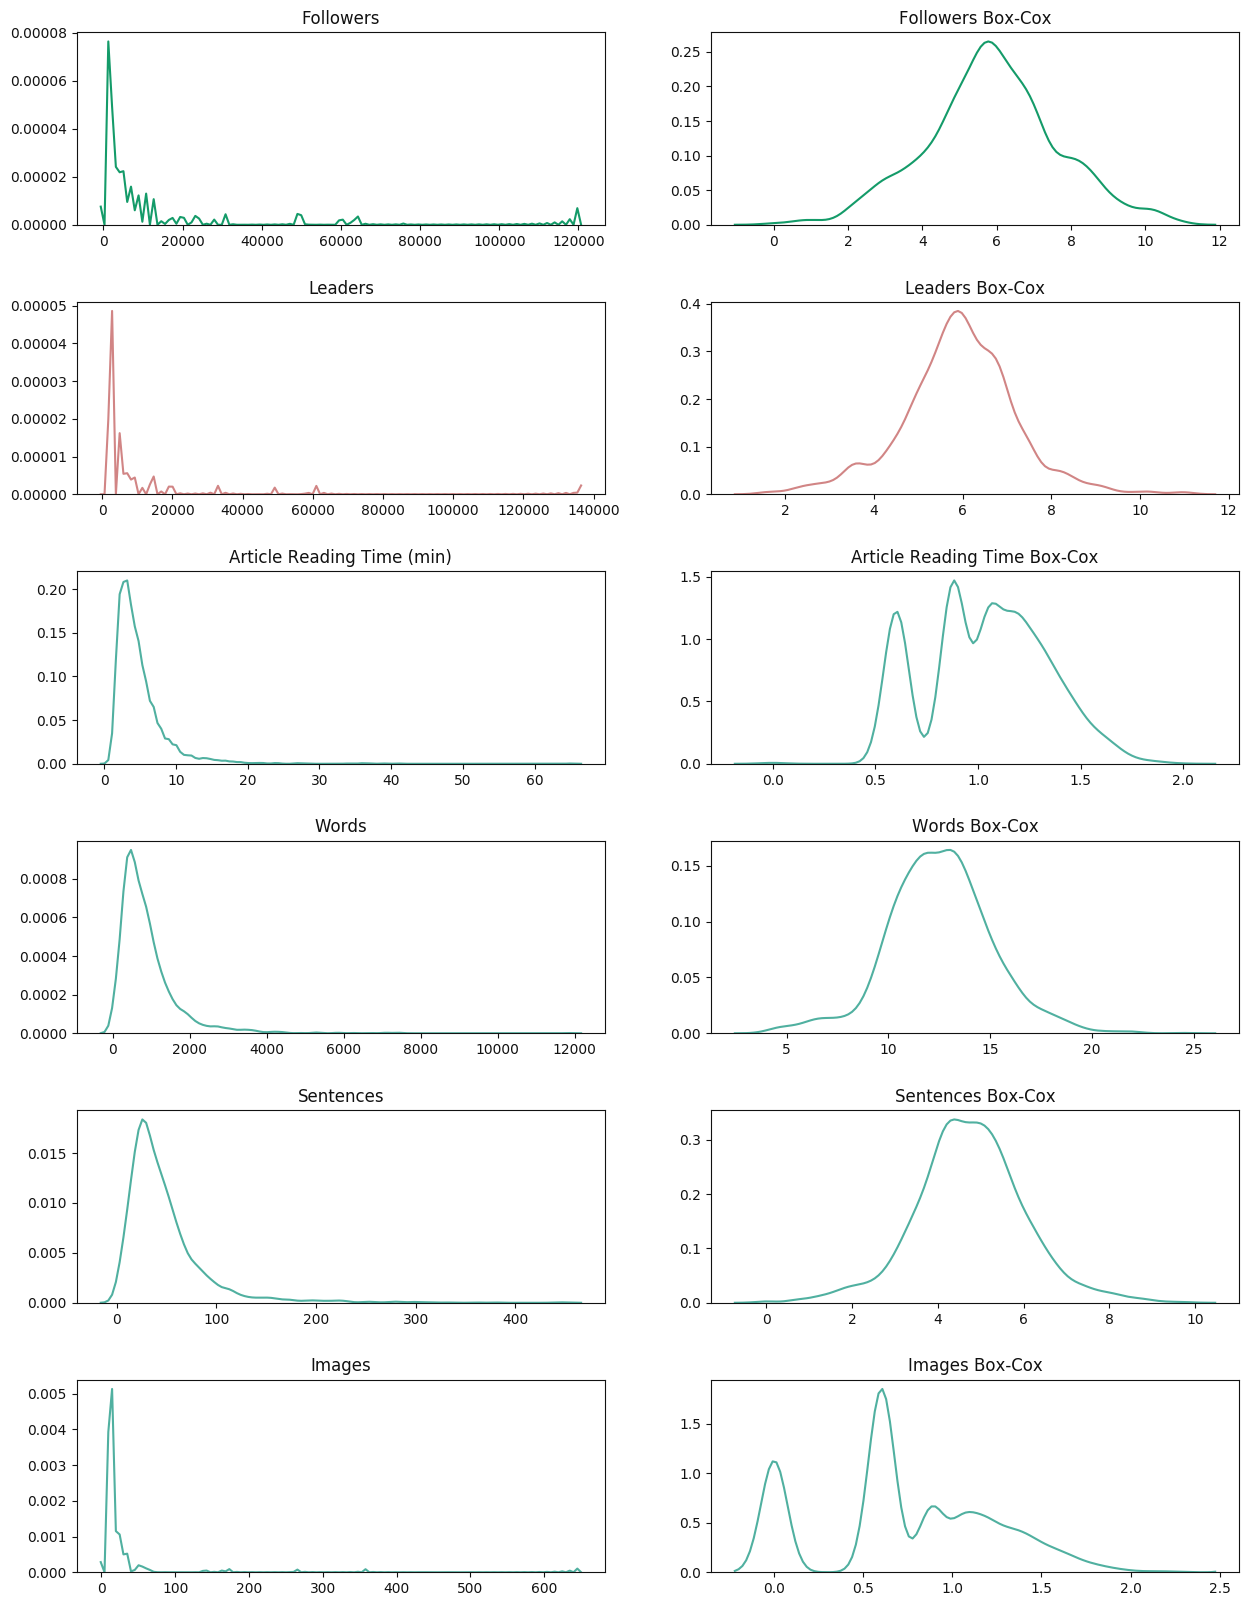

In [874]:
# Evaluate other variable transformations
fig, ax = plt.subplots(6, 2, figsize=(15,20))

plt.subplots_adjust(wspace = 0.2,hspace = 0.4 )

sns.kdeplot(total['followers_num'],ax=ax[0][0], color = '#149B69',legend = False).set_title('Followers')
sns.kdeplot(total['followers_boxcox'],ax=ax[0][1], color = '#149B69',legend = False).set_title('Followers Box-Cox')

sns.kdeplot(total['leaders_num'],ax=ax[1][0], color = '#D18585',legend = False).set_title('Leaders')
sns.kdeplot(total['leaders_boxcox'],ax=ax[1][1], color = '#D18585',legend = False).set_title('Leaders Box-Cox')

sns.kdeplot(total['article_reading_time'],ax=ax[2][0], color = '#50B0A0',legend = False).set_title('Article Reading Time (min)')
sns.kdeplot(total['article_reading_time_boxcox'],ax=ax[2][1], color = '#50B0A0',legend = False).set_title('Article Reading Time Box-Cox')

sns.kdeplot(total['words'],ax=ax[3][0], color = '#50B0A0',legend = False).set_title('Words')
sns.kdeplot(total['words_boxcox'],ax=ax[3][1], color = '#50B0A0',legend = False).set_title('Words Box-Cox')

sns.kdeplot(total['sentences'],ax=ax[4][0], color = '#50B0A0',legend = False).set_title('Sentences')
sns.kdeplot(total['sentences_boxcox'],ax=ax[4][1], color = '#50B0A0',legend = False).set_title('Sentences Box-Cox')

sns.kdeplot(total['images'],ax=ax[5][0], color = '#50B0A0',legend = False).set_title('Images')
sns.kdeplot(total['images_boxcox'],ax=ax[5][1], color = '#50B0A0',legend = False).set_title('Images Box-Cox');


## Look at initial relationships, correlations & 'dumb' linear model

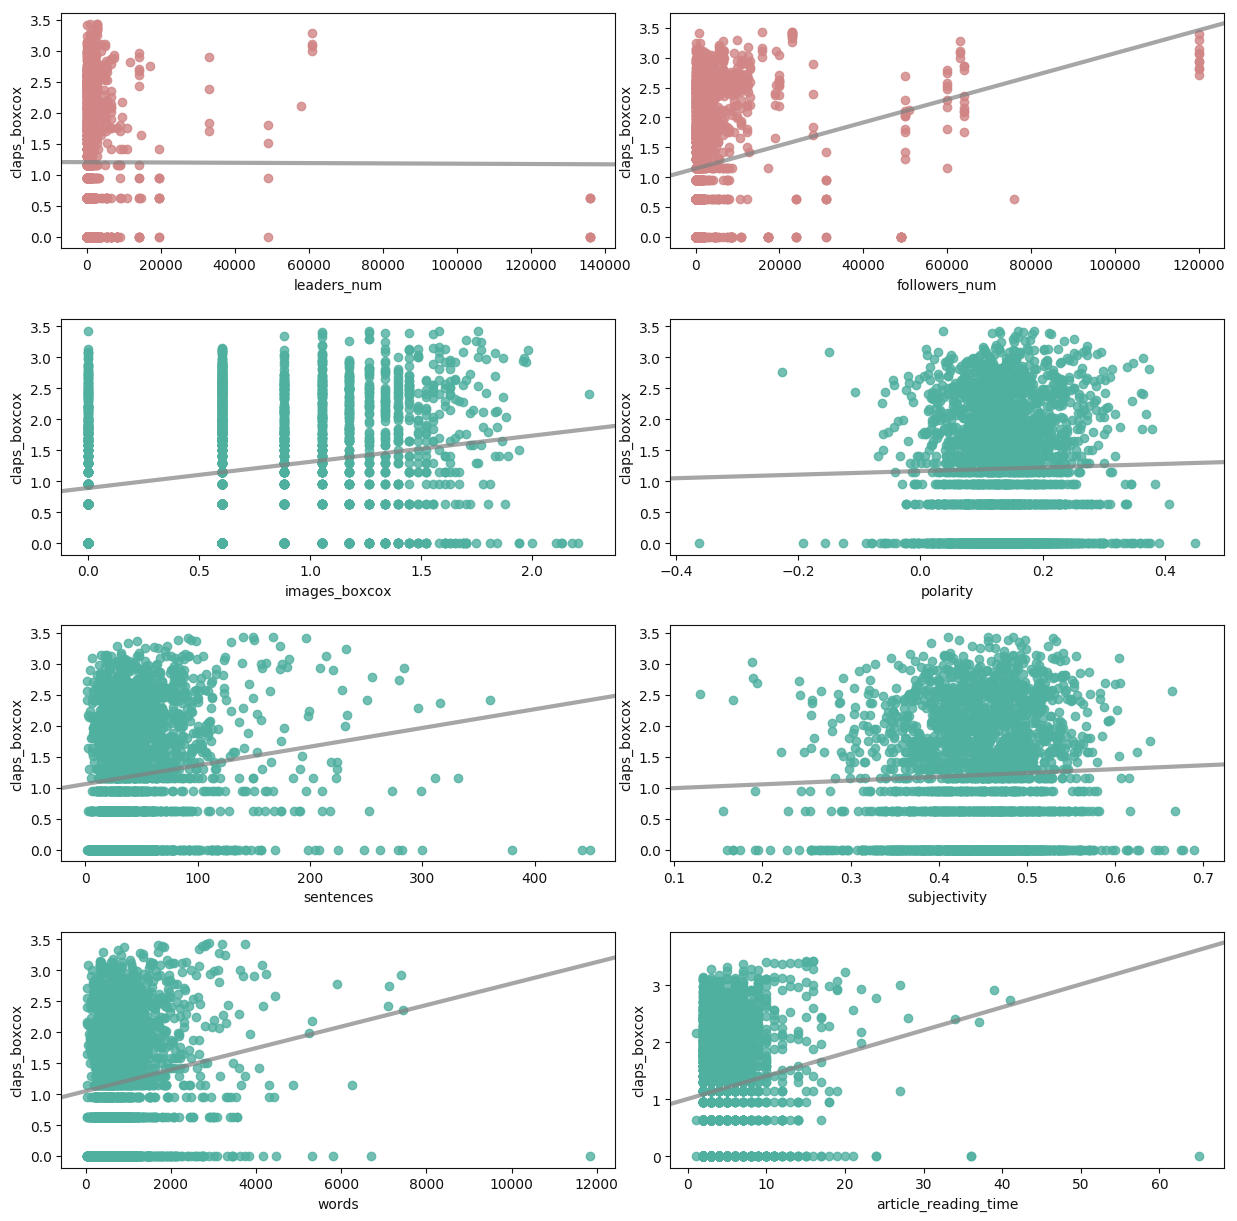

In [875]:
plt.rcParams.update(plt.rcParamsDefault)

fig, ax = plt.subplots(4, 2, figsize=(15,15))

plt.subplots_adjust(wspace = 0.1,hspace = 0.3 )


sns.regplot(total['leaders_num'],total['claps_boxcox'],ax=ax[0][0],line_kws={'color':'grey',"alpha":0.7,"lw":3}, ci=None,color = '#D18585')
sns.regplot(total['followers_num'],total['claps_boxcox'],ax=ax[0][1],line_kws={'color':'grey',"alpha":0.7,"lw":3}, ci=None,color = '#D18585')
sns.regplot(total['images_boxcox'],total['claps_boxcox'],ax=ax[1][0],line_kws={'color':'grey',"alpha":0.7,"lw":3},ci=None,color = '#50B0A0')
sns.regplot(total['polarity'],total['claps_boxcox'],ax=ax[1][1],line_kws={'color':'grey',"alpha":0.7,"lw":3},ci=None,color = '#50B0A0')
sns.regplot(total['sentences'],total['claps_boxcox'],ax=ax[2][0],line_kws={'color':'grey',"alpha":0.7,"lw":3},ci=None,color = '#50B0A0')
sns.regplot(total['subjectivity'],total['claps_boxcox'],ax=ax[2][1],line_kws={'color':'grey',"alpha":0.7,"lw":3},ci=None,color = '#50B0A0')
sns.regplot(total['words'],total['claps_boxcox'],ax=ax[3][0],line_kws={'color':'grey',"alpha":0.7,"lw":3},ci=None,color = '#50B0A0')
sns.regplot(total['article_reading_time'],total['claps_boxcox'],ax=ax[3][1],line_kws={'color':'grey',"alpha":0.7,"lw":3},ci=None,color = '#50B0A0')

In [876]:
# print_columns(total)

In [877]:
# make map that excludes tags
df_heatmap = total.iloc[:, np.r_[3:18,53,54]]
# df_heatmap = total.iloc[:, np.r_[3:18,27,31]]

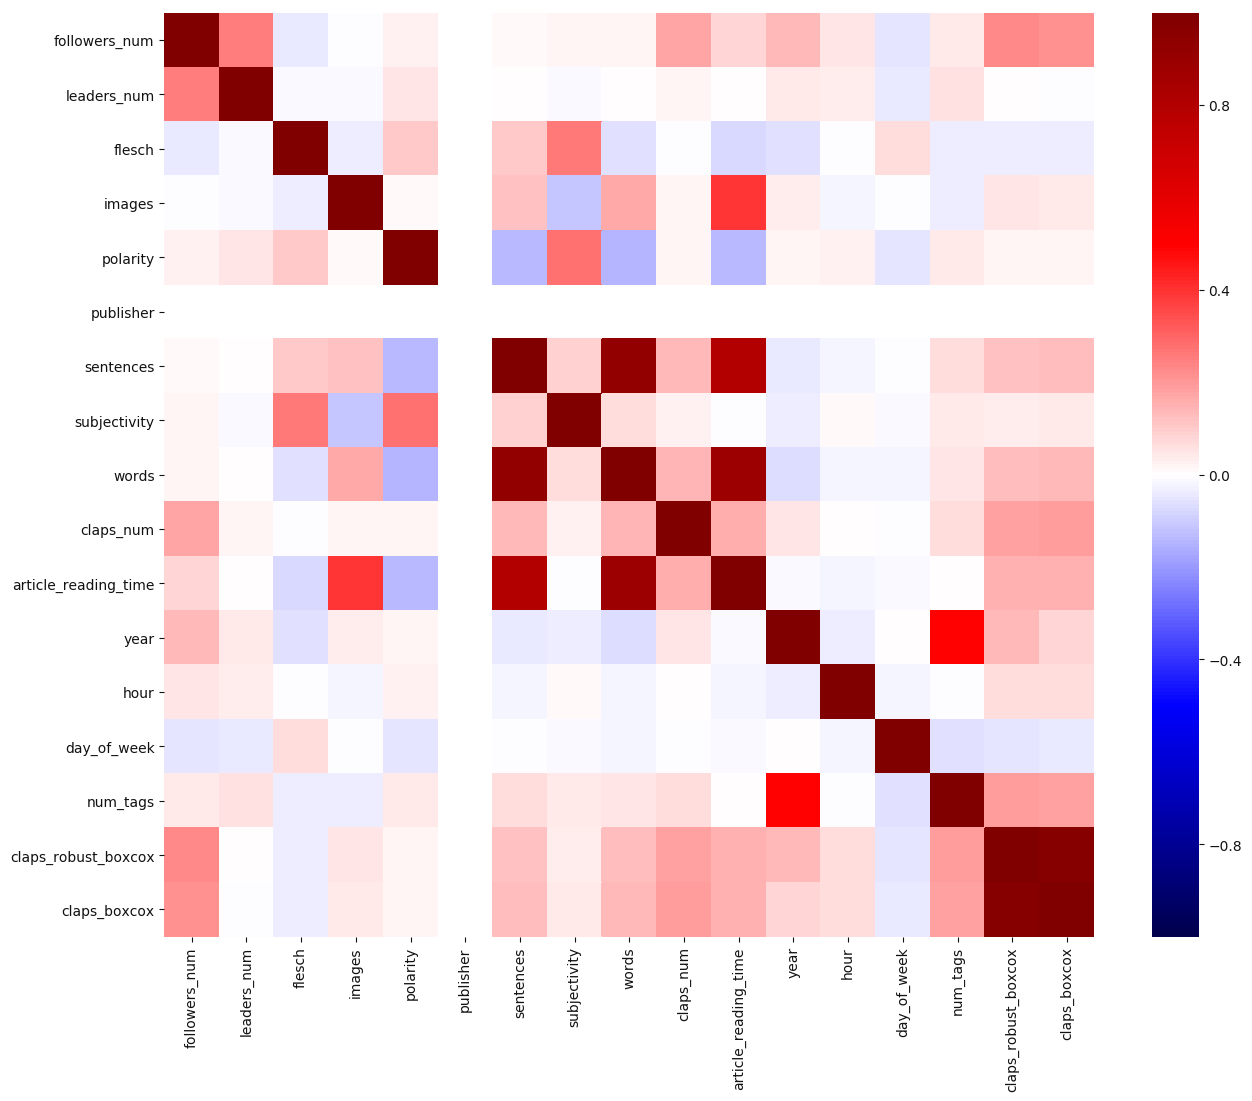

In [878]:
plt.rcParams['figure.figsize'] = [15, 12]
sns.heatmap(df_heatmap.corr(), vmin=-1, vmax =1, cmap = 'seismic')

**Dumb Model Notes**
- ['claps_num'] , ['followers_num','leaders_num','article_reading_time','images']: 0.041
- ['claps_boxcox'] , ['followers_boxcox']: 0.149
- ['claps_boxcox'], ['followers_boxcox', 'leaders_num']: 0.152
- ['claps_boxcox'], ['followers_boxcox', 'leaders_boxcox']: 0.189
- ['claps_boxcox'] , ['followers_boxcox', 'leaders_boxcox', 'images'] : 0.194
- ['claps_boxcox'] , ['followers_boxcox', 'leaders_boxcox', 'images_boxcox']: 0.224

Best model:
X = total[['followers_boxcox','leaders_boxcox', 'images_boxcox', 'publisher', 'article_reading_time', 'subjectivity', 'num_tags' ]]
y = total['claps_boxcox'] 

R-squared:	0.250

Note: Scalar & box cox produces the worst results as a dependent variable


In [879]:
# add in a contant to the data set
total['constant'] = 1

In [880]:
print_columns(total)

0 author
1 name
2 url
3 followers_num
4 leaders_num
5 flesch
6 images
7 polarity
8 publisher
9 sentences
10 subjectivity
11 words
12 claps_num
13 article_reading_time
14 year
15 hour
16 day_of_week
17 num_tags
18 2016 Election
19 AI
20 Artificial Intelligence
21 Big Data
22 Bots
23 Business
24 Data
25 Data Science
26 Data Visualization
27 Design
28 Donald Trump
29 Education
30 Entrepreneurship
31 Government
32 Health
33 Journalism
34 Life
35 Life Lessons
36 Machine Learning
37 Marketing
38 Open Data
39 Politics
40 Product Management
41 Productivity
42 Programming
43 Python
44 Social Media
45 Software Development
46 Sports
47 Startup
48 Tech
49 Technology
50 claps_scalar
51 claps_robust_scalar
52 claps_scalar_boxcox
53 claps_robust_boxcox
54 claps_boxcox
55 leaders_boxcox
56 followers_boxcox
57 article_reading_time_boxcox
58 words_boxcox
59 sentences_boxcox
60 images_boxcox
61 constant


In [881]:
# quantify these relationships with a linear regression 1x1

# X = total[['followers_boxcox','leaders_boxcox', 'images_boxcox', 'publisher', 'article_reading_time', 'subjectivity', 'num_tags' ]]
# y = total['claps_boxcox'] 

X = total.iloc[:, np.r_[3:12,13,17:50,61]]
y = total.iloc[:,54]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 2)

# Note the difference in argument order
model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_test)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           claps_boxcox   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     10.12
Date:                Fri, 27 Apr 2018   Prob (F-statistic):           1.44e-57
Time:                        01:01:34   Log-Likelihood:                -2579.0
No. Observations:                1975   AIC:                             5244.
Df Residuals:                    1932   BIC:                             5484.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
followers_num            2.062e-05   2.09e-06      9.863      0.000    1.65e-05    2.47e-05
leaders_num             -9.453e-06    3.2e-06     -2.956      0.003   -1.57e-05   -3.18e-06
flesch                      0.0008      0.002      0.359      0.719      -0.003       0.005
images                     -0.0001      0.001     -0.088      0.930      -0.003       0.003
polarity                   -0.0742      0.298     -0.249      0.803      -0.658       0.510
publisher                   0.2655      0.094      2.809      0.005       0.080       0.451
sentences                   0.0021      0.001      1.405      0.160      -0.001       0.005
subjectivity                0.0913      0.342      0.267      0.790      -0.580       0.763
words                    -8.61e-05   9.64e-05     -0.893      0.372      -0.000       0.000
article_reading_time        0.0296      0.014      2.095      0.036       0.002       0.057
num_tags                    0.0796      0.013      5.938      0.000       0.053       0.106
2016 Election               0.1882      0.130      1.446      0.148      -0.067       0.444
AI                          0.3109      0.157      1.984      0.047       0.004       0.618
Artificial Intelligence     0.3193      0.105      3.031      0.002       0.113       0.526
Big Data                   -0.3543      0.114     -3.107      0.002      -0.578      -0.131
Bots                        0.2121      0.162      1.309      0.191      -0.106       0.530
Business                    0.1947      0.151      1.289      0.198      -0.102       0.491
Data                        0.1841      0.140      1.318      0.188      -0.090       0.458
Data Science                0.4136      0.084      4.938      0.000       0.249       0.578
Data Visualization          0.3509      0.146      2.406      0.016       0.065       0.637
Design                      0.2541      0.134      1.899      0.058      -0.008       0.517
Donald Trump               -0.1792      0.137     -1.306      0.192      -0.448       0.090
Education                  -0.0806      0.153     -0.526      0.599      -0.381       0.220
Entrepreneurship            0.1418      0.126      1.124      0.261      -0.106       0.389
Government                 -0.1142      0.151     -0.757      0.449      -0.410       0.182
Health                     -0.1556      0.161     -0.967      0.334      -0.471       0.160
Journalism                  0.5826      0.126      4.629      0.000       0.336       0.829
Life                        0.4907      0.161      3.051      0.002       0.175       0.806
Life Lessons                0.0207      0.164      0.126      0.900      -0.301       0.342
Machine Learning            0.2787      0.107      2.601      0.009       0.069       0.489
Marketing                  -0.2343      0.180  

# Iterate through polynomials & regularizations

## Find best model

In [888]:
import warnings
warnings.filterwarnings("ignore")

In [889]:
#run a for loop to select the base claps transformation
# claps_var = [53,54,55]
# for i in claps_var:
#     X = total.iloc[:, np.r_[5,7:11,12,14,18:51,56,57,61]]
#     y = total.iloc[:,i]
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
#     l1rat = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
#     alphas = [.01,.1,1,1e2,15,20,50,1e3]
#     degree = 2
#     est = make_pipeline(PolynomialFeatures(2), ElasticNetCV(l1_ratio = l1rat, alphas = alphas, cv = 5, selection = 'random'))
#     est.fit(X_train, y_train)
#     rmse = np.sqrt(mean_squared_error(y_test, est.predict(X_test)))
#     print("alpha =", est.named_steps.elasticnetcv.alpha_, "l1_ratio =",
#       est.named_steps.elasticnetcv.l1_ratio_)
#     print(i,est.score(X_train, y_train),est.score(X_test,y_test), rmse)

**Best performance:**
- 55: claps_boxcox
- alpha = 50.0
- l1_ratio = 0.4
- trainr: 0.2691079330910998
- testr: 0.23384655408161312 
- rmse: 0.8786169497537989

alpha = 1.0 l1_ratio = 0.9
53 0.26227048462791736 0.1691694496367241 0.09229174524638362
alpha = 15.0 l1_ratio = 0.7
54 0.2708883535022738 0.21513297535296105 0.30908742285529217
alpha = 50.0 l1_ratio = 0.4
55 0.2691079330910998 0.23384655408161312 0.8786169497537989

In [890]:
X = total.iloc[:, np.r_[5,7:11,13,17:50,55,56,60]]
y = total.iloc[:,54]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state= 2) 

In [891]:
## Try out with a simple linear regression


# degree = 2
# est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
# fit = est.fit(X_train, y_train)
# rmse = np.sqrt(mean_squared_error(y_test, est.predict(X_test)))
# (est.score(X_train, y_train),est.score(X_test,y_test), rmse)

In [892]:
## Refine best model

l1rat = 0.2
alphas = [0.01,.03,.1,.2,.3,.5]
degree = 2
est = make_pipeline(PolynomialFeatures(degree), ElasticNetCV(l1_ratio = l1rat, alphas = alphas, cv = 5))
fit = est.fit(X_train, y_train)
rmse = np.sqrt(mean_squared_error(y_test, est.predict(X_test)))
print("alpha =", est.named_steps.elasticnetcv.alpha_, "l1_ratio =",
      est.named_steps.elasticnetcv.l1_ratio_)
print(est.score(X_train, y_train),est.score(X_test,y_test), rmse)

alpha = 0.5 l1_ratio = 0.2
0.33736865614899614 0.26719055393343805 0.8402169071080713


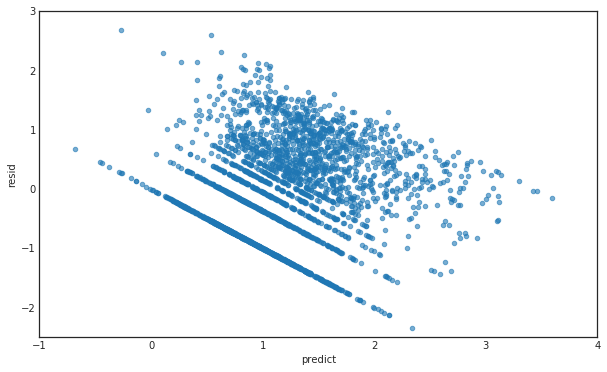

In [974]:
#plot un-transformed resids
data = pd.DataFrame(y)
data['predict']=fit.predict(X)
data['resid']=data.claps_boxcox-data.predict
with sns.axes_style('white'):
    plot=data.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.6,figsize=(10,6), xlim = (-1,4), ylim = (-2.5,3))

In [975]:
## Untangle model results

In [976]:
#Undo the box-cox to calculate residuals in true units
data['pred_undo'] = special.inv_boxcox(data['predict'],claps_boxcox_lmb)-1
data['claps_undo'] = special.inv_boxcox(data['claps_boxcox'],claps_boxcox_lmb)-1


In [977]:
data['residual_undo'] = data['claps_undo'] - data['pred_undo']

In [978]:
data.sort_values('claps_undo', ascending = False).head()

,claps_boxcox,predict,resid,pred_undo,claps_undo,residual_undo
1809,3.433632,3.588916,-0.155284,7.934594e+06,37000.0,-7.897594e+06
1811,3.427197,3.296743,0.130454,5.609869e+03,33000.0,2.739013e+04
2537,3.427197,3.457112,-0.029915,5.808411e+04,33000.0,-2.508411e+04
1443,3.419682,2.124735,1.294948,2.335590e+01,29000.0,2.897664e+04
1813,3.413120,2.949105,0.464014,4.283230e+02,26000.0,2.557168e+04


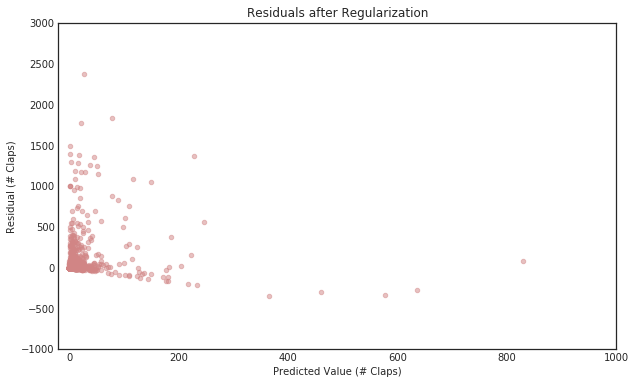

In [988]:
#plot transformed residuals
with sns.axes_style('white'):
    plot=data.plot(kind='scatter',
                  x='pred_undo',y='residual_undo',alpha=0.5,figsize=(10,6), xlim=(-20,1000),ylim=(-1000,3000), color = '#D18585')
    plt.xlabel('Predicted Value (# Claps)')
    plt.ylabel('Residual (# Claps)')
    plt.title('Residuals after Regularization')

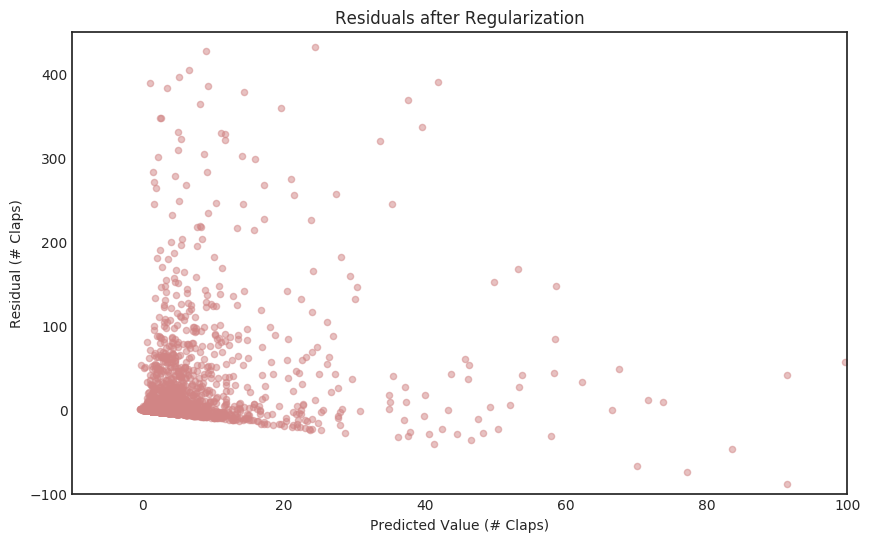

In [897]:
#plot transformed residuals
with sns.axes_style('white'):
    plot=data.plot(kind='scatter',
                  x='pred_undo',y='residual_undo',alpha=0.5,figsize=(10,6), xlim=(-10,100),ylim=(-100,450), color = '#D18585')
    plt.xlabel('Predicted Value (# Claps)')
    plt.ylabel('Residual (# Claps)')
    plt.title('Residuals after Regularization')

In [898]:
## Translate RMSE back to claps - claps_boxcox
rmse = 0.8786169497537989
special.inv_boxcox(rmse,claps_boxcox_lmb)

2.73401909735509

In [923]:
## get coefficients
coef_df = pd.DataFrame(columns=['feature','coefficient'])
coef_df['feature'] = poly.get_feature_names(X.columns)
coef_df['coefficient'] = est.steps[-1][1].coef_.ravel()
coef_df['sort'] = coef_df.coefficient.abs()
coef_df[coef_df['coefficient'] != 0].sort_values('sort', ascending = False)

,feature,coefficient,sort
244,article_reading_time num_tags,0.022206,0.022206
940,leaders_boxcox^2,-0.012807,0.012807
943,followers_boxcox^2,0.009494,0.009494
4,sentences,0.005674,0.005674
65,flesch Journalism,0.005129,0.005129
278,article_reading_time followers_boxcox,-0.005127,0.005127
53,flesch Big Data,-0.004420,0.004420
66,flesch Life,0.004308,0.004308
57,flesch Data Science,0.004305,0.004305
127,publisher sentences,0.003926,0.003926


In [900]:
special.inv_boxcox(0.009494,claps_boxcox_lmb)+1

2.0095517499635323

# Descriptive plots

## Dive into significant coefficients visually

In [901]:
#work with a test dataset so I don't mess up earlier parts
test = total

Text(0.5,1,'Post Reading Time vs. Claps')

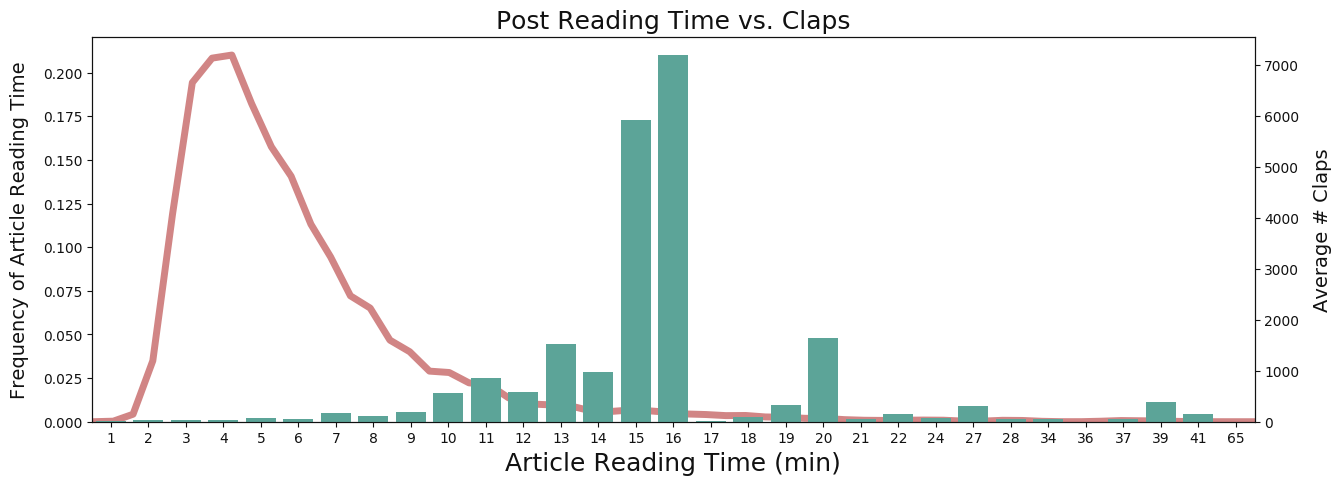

In [903]:
plt.rcParams['figure.figsize'] = [15, 5]

fig, ax = plt.subplots()

ax2 =ax.twinx()
sns.barplot(x="article_reading_time", y="claps_num", data=test,estimator=np.mean, ci= None, ax = ax2, color = '#50B0A0')
sns.kdeplot(test["article_reading_time"], ax = ax, color = '#D18585',lw=5,legend = False)
ax.set_xlabel('Article Reading Time (min)', fontsize=18)
ax2.set_ylabel('Average # Claps', fontsize=14, labelpad = 10)
ax.set_ylabel('Frequency of Article Reading Time',fontsize=14,labelpad = 10)
plt.title('Post Reading Time vs. Claps', fontsize=18)

            

Text(0.5,1,'# Tags vs. Claps')

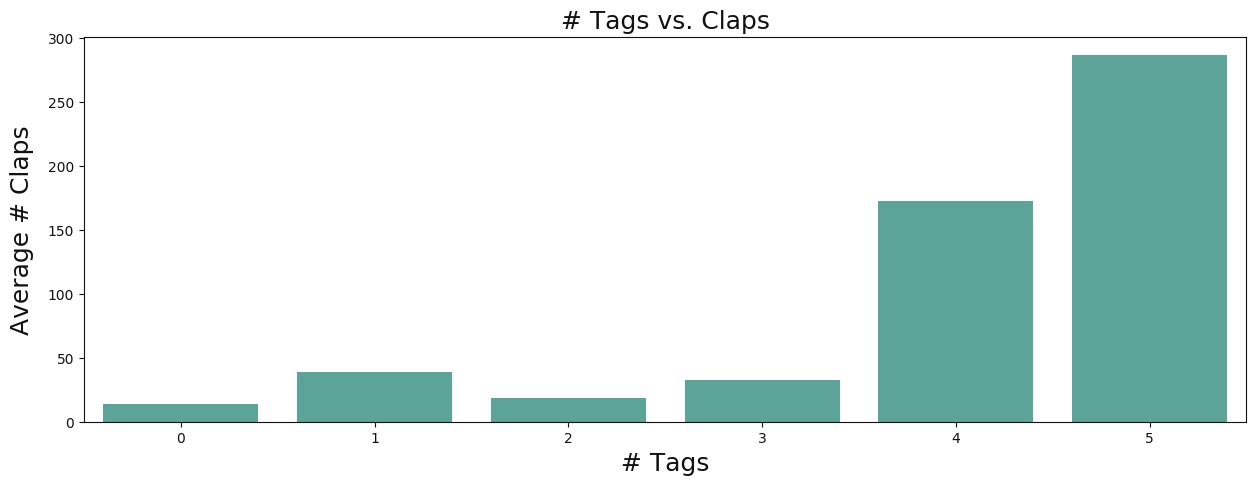

In [904]:
plt.rcParams['figure.figsize'] = [15, 5]

fig, ax = plt.subplots()

sns.barplot(x="num_tags", y="claps_num", data=test,estimator=np.mean, ci= None, ax = ax, color = '#50B0A0')
ax.set_xlabel('# Tags', fontsize=18)
ax.set_ylabel('Average # Claps',fontsize=18,labelpad = 10)
plt.title('# Tags vs. Claps', fontsize=18)


Text(0.5,1,'# Leaders vs Claps')

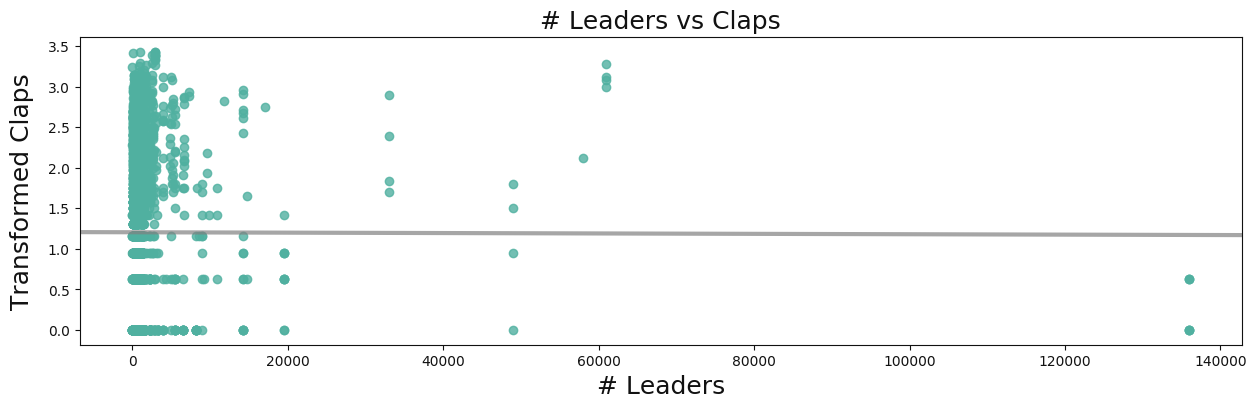

In [905]:
## Leaders and followers
plt.rcParams['figure.figsize'] = [15, 4]

# ax1 = sns.regplot(total['followers_num'],total['claps_boxcox'],line_kws={'color':'grey',"alpha":0.7,"lw":3}, ci=None,color = '#D18585')
# ax.set_xlabel('# Followers', fontsize=18)
# ax.set_ylabel('Transformed Claps',fontsize=18,labelpad = 10)
# plt.title('# Followers vs Claps', fontsize=18)

ax2 = sns.regplot(total['leaders_num'],total['claps_boxcox'],line_kws={'color':'grey',"alpha":0.7,"lw":3}, ci=None,color = '#50B0A0')
ax2.set_xlabel('# Leaders', fontsize=18)
ax2.set_ylabel('Transformed Claps',fontsize=18,labelpad = 10)
plt.title('# Leaders vs Claps', fontsize=18)


In [906]:
#look at some large outliers
people = test.groupby(['author']).agg({"followers_num": np.mean,"url": pd.Series.nunique, "claps_num": np.mean})
people['claps_to_followers'] = people['claps_num']/people['followers_num']


In [907]:
people.sort_values('followers_num', ascending = False);

## Get average claps per tag

In [908]:
tags_list = []
for x in list(test.columns)[18:50]:
    tags_list.append(x)

In [909]:
test.groupby(['Government']).agg({"claps_num": np.mean}).T

Government,0,1
claps_num,155.012398,21.716981


In [910]:
avg_tag_clap = []
for i in tags_list:
    claps = list(test.groupby([i]).agg({"claps_num": np.mean}).T[1])[0]
    avg_tag_clap.append(claps)

In [911]:
tags_count_df = pd.DataFrame(columns=['tag','avg_claps'])

In [912]:
tags_count_df['tag'] = tags_list
tags_count_df['avg_claps'] =avg_tag_clap

In [913]:
tags_count_df = tags_count_df.sort_values('avg_claps', ascending = True)

In [914]:
tags_count_df.reset_index()

,index,tag,avg_claps
0,28,Sports,8.365854
1,11,Education,10.162791
2,19,Marketing,17.829268
3,13,Government,21.716981
4,21,Politics,22.203704
5,3,Big Data,22.428571
6,25,Python,24.686275
7,26,Social Media,25.445652
8,10,Donald Trump,25.507246
9,20,Open Data,26.207547


Text(0.5,1,'Top Claps Tags')

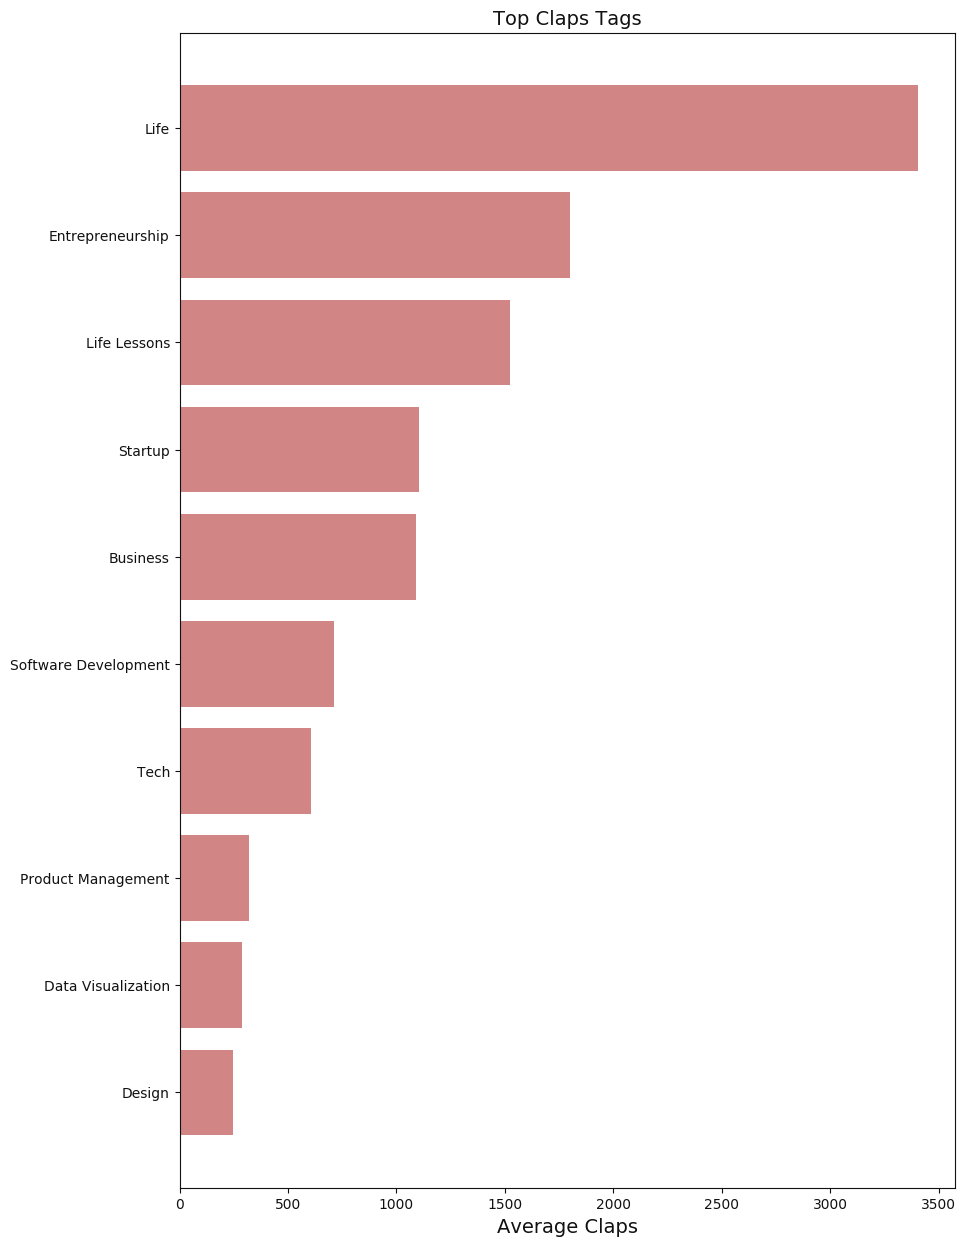

In [915]:
plt.rcParams['figure.figsize'] = [10, 15]

plt.barh("tag","avg_claps", data = tags_count_df[-10:], color = '#D18585' )
ax.yaxis.label.set_fontsize(20)

plt.xlabel('Average Claps', fontsize=14)
plt.title('Top Claps Tags', fontsize=14)



In [916]:
list(total[total['claps_num']==17800.0]['url'])

['https://medium.com/@michaeldsimmons/forget-about-the-10-000-hour-rule-7b7a39343523']

## Look at claps over the week

Text(0,0.5,'Total Articles')

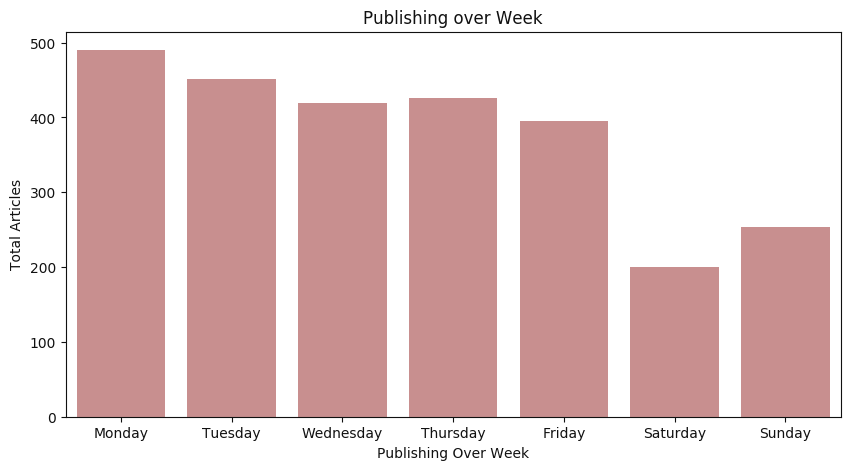

In [924]:
plt.subplots( figsize=(10,5))
# ax = sns.kdeplot(total['day_of_week'], color = '#50B0A0',legend = False).set_title('Claps per Article')
ax = sns.countplot(test['day_of_week'], color = '#D18585').set_title('Publishing over Week')
ax.axes.set_xticklabels(labels)
labels= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xlabel('Publishing Over Week')
plt.ylabel('Total Articles')


## Look at relationship w/ publishers

In [931]:
total[['publisher']].describe()

,publisher
count,2634.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


Text(0.5,1,'Publisher Impact')

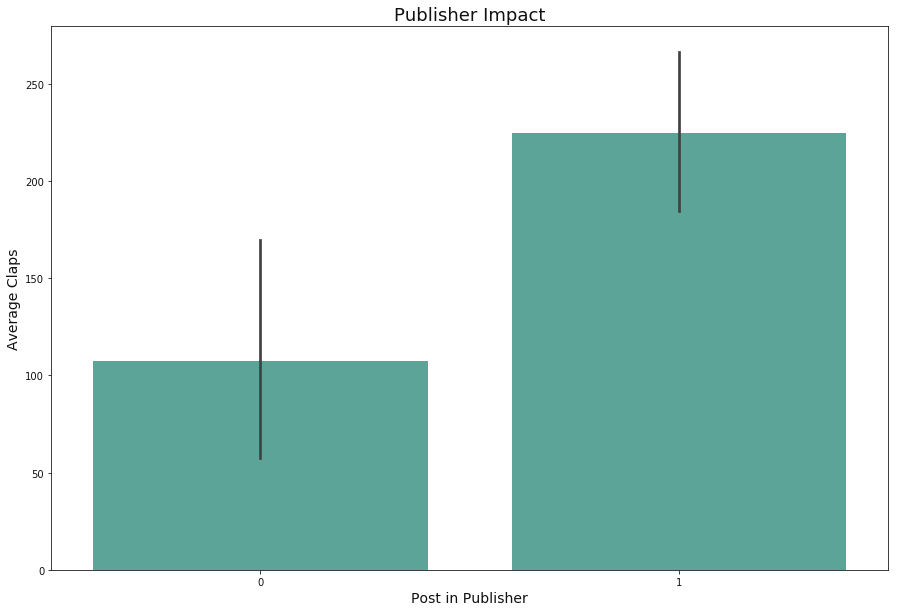

In [961]:
plt.rcParams['figure.figsize'] = [15, 10]

sns.barplot(x="publisher", y="claps_num", data=df_m,estimator=np.mean, ci=80, color ='#50B0A0' )
plt.xlabel('Post in Publisher',fontsize=14 )
plt.ylabel('Average Claps',fontsize=14)
plt.title('Publisher Impact', fontsize = 18)

In [969]:
# has_pub = list(test[test['publisher'] ==1]['claps_num'])
# no_pub =  list(test[test['publisher'] ==0]['claps_num'])

has_pub = list(df_m[df_m['publisher'] ==1]['claps_num'])
no_pub =  list(df_m[df_m['publisher'] ==0]['claps_num'])

In [970]:
#check signif between groups
stats.f_oneway(has_pub,no_pub)

F_onewayResult(statistic=3.3673316001311937, pvalue=0.06658911032476493)